# Three-armed Bayesian Bernoulli Bandits

It is important to note that a belief is defined by the value of each 
hyperparameter, which is an integer going from $0$ to $\infty$.

To find an approximate MDP with a finite state space we can note that the discount factor $\gamma$ (which appears in the exponentially discounted return) introduces a time scale, since one can interpret it as the probability of continuing the game after each step.
In particular the quantity $1/(1-\gamma)$, i.e. the **time horizon**, is the number of time steps that the player expects to play (on average).
Therefore, it is very unlikely that the game can last for a time much greater than the time horizon. 

In order to find a more quantitative rule to fix the boundary of the state space, one can consider the probability that the game lasts for more that $T$ steps: $P(t>T) = \gamma^T$.
If $T$ is chosen such that this probability is small: $P(t>T) = \epsilon$, one finds:

$$
T = \log{\epsilon} \; / \; \log{\gamma}
$$


21


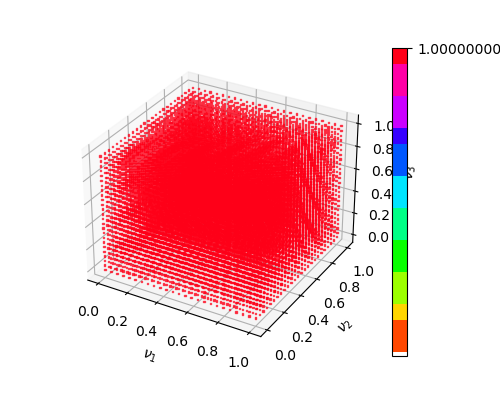

In [32]:
%matplotlib widget
import numpy as np
import pandas as pd
from scipy.stats import beta
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement as Comb_rep
K = 3       # No. Arms ()
gamma = 0.9 # Discount Factor
eps = 1e-1  # Precision of the approximation
T = int(np.log(eps)/np.log(gamma))
print(T)
def belief_state(state):
  Nbins = 25
  nu = [None]*K
  for i, (a, b) in enumerate(state):
    nu[i] = beta(a, b).pdf
  coords = np.meshgrid(*[np.linspace(0, 1, Nbins)]*K)
  S = nu[0](coords[0])
  for i, x in enumerate(coords[1:]):
    S *= nu[i](x)
  S = S.reshape(*[Nbins]*K)[::-1,:]
  fig = plt.figure(figsize=(5, 4))
  if K == 2:
    extent = [0, 1, 0, 1]
    plt.xlabel("$\\nu_1$")
    plt.ylabel("$\\nu_2$")
    plt.imshow(S, extent=extent)
  elif K == 3:
    data = np.array([*coords, S]).reshape(K + 1, -1)
    data = pd.DataFrame(data={x: y for x, y in zip(["X", "Y", "Z", "C"], data)})
    ax = fig.add_subplot(111, projection='3d')
    color_map = plt.cm.ScalarMappable(cmap=plt.cm.hsv)
    color_map.set_array(data["C"])
    img = ax.scatter(data["X"], data["Y"], data["Z"], marker='s', s=1,
                     c=plt.cm.hsv(data["C"]/max(data["C"])), alpha=0.7)
    plt.colorbar(color_map)
    ax.set_xlabel("$\\nu_1$")
    ax.set_ylabel("$\\nu_2$")
    ax.set_zlabel("$\\nu_3$")
  plt.show()
  return

belief_state([(1, 1) for _ in range(K)])

In [2]:
def partitions(n, b):
  masks = np.identity(b, dtype=int)
  for c in Comb_rep(masks, n):
    yield sum(c)

def states(N):
  if N == 0:
    S = np.array(list(partitions(N, K*2))) + np.ones(K*2, dtype=int)
    return [tuple([(S[2*j], S[2*j + 1]) for j in range(K)])]
  return [tuple([(i[2*j], i[2*j + 1]) for j in range(K)])
          for i in np.array(list(partitions(N, K*2))) + np.ones(K*2)]
states(2)

[((3.0, 1.0), (1.0, 1.0), (1.0, 1.0)),
 ((2.0, 2.0), (1.0, 1.0), (1.0, 1.0)),
 ((2.0, 1.0), (2.0, 1.0), (1.0, 1.0)),
 ((2.0, 1.0), (1.0, 2.0), (1.0, 1.0)),
 ((2.0, 1.0), (1.0, 1.0), (2.0, 1.0)),
 ((2.0, 1.0), (1.0, 1.0), (1.0, 2.0)),
 ((1.0, 3.0), (1.0, 1.0), (1.0, 1.0)),
 ((1.0, 2.0), (2.0, 1.0), (1.0, 1.0)),
 ((1.0, 2.0), (1.0, 2.0), (1.0, 1.0)),
 ((1.0, 2.0), (1.0, 1.0), (2.0, 1.0)),
 ((1.0, 2.0), (1.0, 1.0), (1.0, 2.0)),
 ((1.0, 1.0), (3.0, 1.0), (1.0, 1.0)),
 ((1.0, 1.0), (2.0, 2.0), (1.0, 1.0)),
 ((1.0, 1.0), (2.0, 1.0), (2.0, 1.0)),
 ((1.0, 1.0), (2.0, 1.0), (1.0, 2.0)),
 ((1.0, 1.0), (1.0, 3.0), (1.0, 1.0)),
 ((1.0, 1.0), (1.0, 2.0), (2.0, 1.0)),
 ((1.0, 1.0), (1.0, 2.0), (1.0, 2.0)),
 ((1.0, 1.0), (1.0, 1.0), (3.0, 1.0)),
 ((1.0, 1.0), (1.0, 1.0), (2.0, 2.0)),
 ((1.0, 1.0), (1.0, 1.0), (1.0, 3.0))]

In [3]:
Values = dict()
for state in states(T):
  q = [state[i][0]/np.sum(state[i]) for i in range(K)]
  Values[state] = (max(q)/(1 - gamma), np.argmax(q))

def compute_value(state):
  w = [state[i][0]/np.sum(state[i]) for i in range(K)]
  Q = [w[i]*(1 + gamma*Values[tuple([(state[j][0] + int(j == i), state[j][1])
                               for j in range(K)])][0]) + \
       (1 - w[i])*gamma*Values[tuple([(state[j][0], state[j][1] + int(j == i))
                                for j in range(K)])][0]
       for i in range(K)]
  return (max(Q), np.argmax(Q))

for t in range(T)[::-1]:
  for state in states(t):
    Values[state] = compute_value(state)

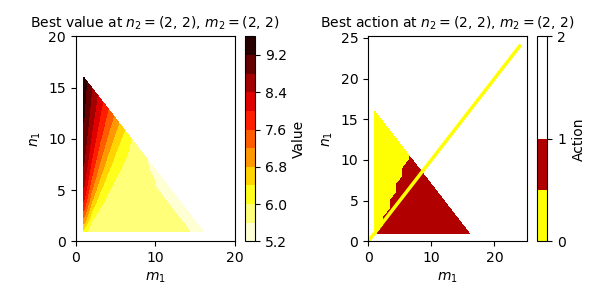

In [39]:
%matplotlib widget
s2 = [(2, 2) for _ in range(K - 1)]
V_mat = -np.ones((2, T, T))
for s in range(1, T):
  for f in range(1, T):
    if s + f + np.sum(s2) - 4 <= T:
      V_mat[:, s, f] = Values[((s, f), *s2)]
values_mat = np.ma.masked_where(V_mat[0] == -1, V_mat[0])
best_a_mat = np.ma.masked_where(V_mat[1] == -1, V_mat[1])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,3))

ax1.set_title('Best value at $n_2=${}, $m_2=${}'.format(*s2), fontsize=10)
ax1.set_xlabel('$m_1$', fontsize=10)
ax1.set_ylabel('$n_1$', fontsize=10)
im = ax1.contourf(values_mat, cmap='hot_r', levels=10)
bar = fig.colorbar(im, ax=ax1)
bar.set_label('Value', fontsize=10)

ax2.set_title('Best action at $n_2=${}, $m_2=${}'.format(*s2), fontsize=10)
ax2.set_xlabel('$m_1$', fontsize=10)
ax2.set_ylabel('$n_1$', fontsize=10)
cs = ax2.contourf(best_a_mat, cmap='hot_r', levels=1)
bar = fig.colorbar(cs, ax=ax2)
bar.set_label('Action', fontsize=10)
bar.set_ticks(range(K))


x = np.arange(25)
y = np.arange(25)
ax2.plot(x,y, linewidth=2.5, c="yellow")
plt.gcf().set_facecolor('white')

plt.tight_layout()

[0.60367592 0.25764502 0.72144963]
State: ((1, 1), (1, 1), (1, 1)), Arm: 0, Reward: Win


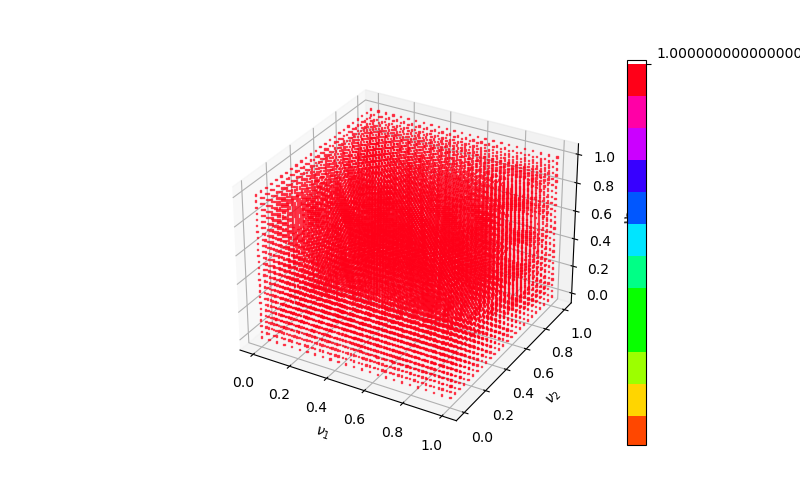

State: ((5, 1), (1, 1), (1, 1)), Arm: 0, Reward: Fail


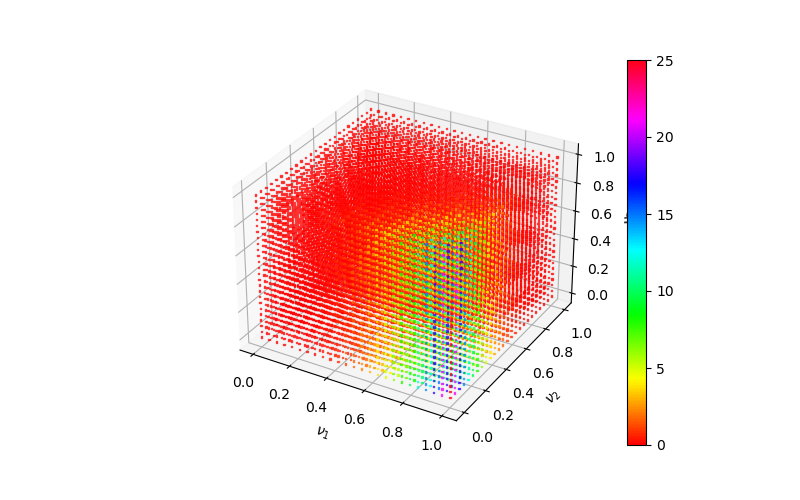

State: ((7, 3), (1, 1), (1, 1)), Arm: 0, Reward: Fail


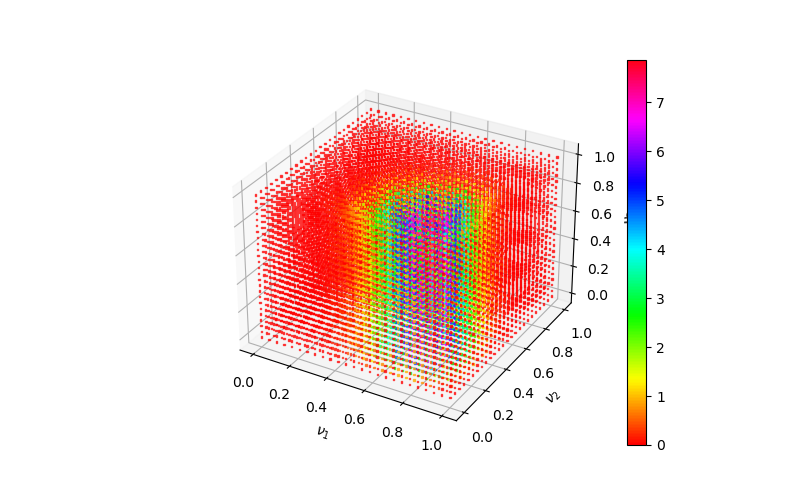

State: ((7, 4), (1, 2), (2, 2)), Arm: 0, Reward: Win


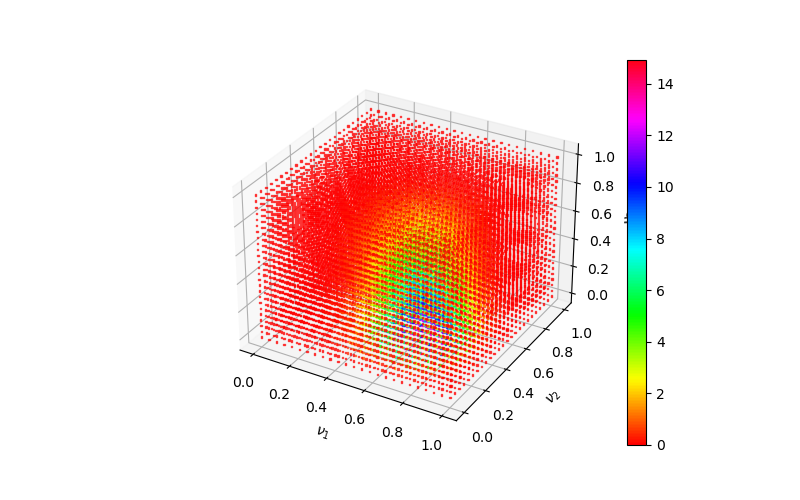

State: ((11, 4), (1, 2), (2, 2)), Arm: 0, Reward: Win


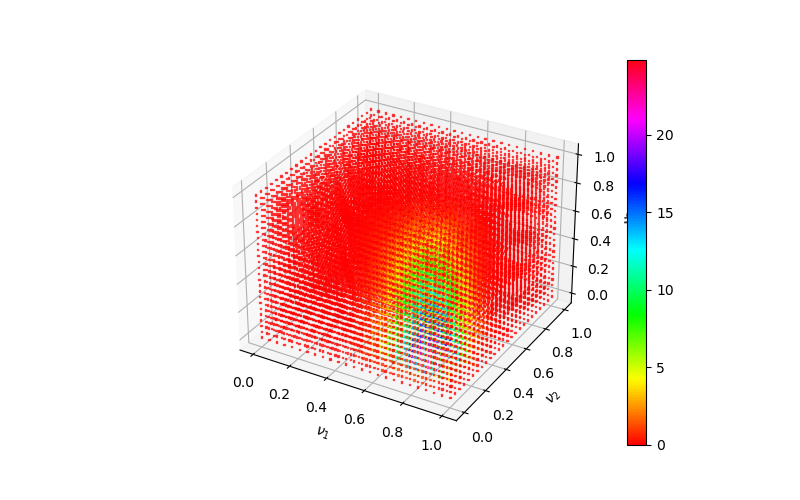

In [31]:
%matplotlib widget
state = [[1, 1] for _ in range(K)]
rho = (np.random.uniform(size=K))
print(rho)
str_res = ("Fail", "Win")
step = 4
for i in range(T - 1):
  s = tuple([tuple(state[i]) for i in range(K)])
  res = np.random.binomial(1, rho[Values[s][1]])
  if (i % step == 0):
    print(f"State: {s}, Arm: {Values[s][1]}, Reward: {str_res[res]}")
    belief_state(s)
  state[Values[s][1]][int(res != 1)] += 1

# Explore Then Commit (ETC) algorithm

In [46]:
def etc(m):
  rho = np.random.uniform(size=K)
  state = [[1, 1] for _ in range(K)]
  print(f"Explore: {rho}")
  for _ in range(m):
    for i in range(K):
      state[i][np.random.binomial(1, rho[i]) != 1] += 1
  i = np.argmax([state[i][0]/np.sum(state[i]) for i in range(K)])
  print(f"Commit: {state}, {i}")
  for _ in range(m*K + 1, T):
    state[i][np.random.binomial(1, rho[i]) != 1] += 1
  print(f"Result: {state}")
etc(4)

Explore: [0.91803346 0.02326148 0.92267938]
Commit: [[5, 1], [2, 4], [5, 1]], 0
Result: [[13, 1], [2, 4], [5, 1]]


# Explore Then Commit (ETC) with Elimination (ETCE) algorithm

In [61]:
def etce(l):
  rho = np.random.uniform(size=K)
  print(rho)
  state = [[1, 1] for _ in range(K)]
  m = [int(T/l) for _ in range(l - 1)]
  m.append(T - int(T/l)*(l - 1))
  A = {i for i in range(K)}
  for l, t in enumerate(m):
    for _ in range(t):
      for i in A:
        state[i][np.random.binomial(1, rho[i]) != 1] += 1
    mu = {i: state[i][0]/np.sum(state[i]) for i in A}
    mu_max = max(mu.values())
    A = {i for i in A if mu[i] + 2**-l >= mu_max}
    for i in A:
      state[i] = [1, 1]
    print(mu)

etce(5)

[0.65192559 0.21928249 0.39201125]
{0: 0.6666666666666666, 1: 0.16666666666666666, 2: 0.16666666666666666}
{0: 0.5, 1: 0.3333333333333333, 2: 0.5}
{0: 0.5, 1: 0.3333333333333333, 2: 0.5}
{0: 0.6666666666666666, 1: 0.16666666666666666, 2: 0.3333333333333333}
{0: 0.7142857142857143}
